In [1]:
import sys
sys.path.append('../src/')

import decode_mcd
import decode_mcd.multi_objective_problem as MOP
from decode_mcd import data_package
from decode_mcd import design_targets
from decode_mcd import counterfactuals_generator

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
def validity(_x): #Validity function for the 2D case
    a = _x["X"] #Separate the two dimensions for clarity
    b = _x["Y"]
    fc = np.less(np.sqrt( np.power((a-0.3), 2) + np.power((b-0.3), 2)), 0.1) #Circle
    sc = np.less(np.power(np.power(np.power((a-b), 6)-1, 2) + np.power(np.power((a+b), 6)-1, 2), 2), 0.99) #Arcs
    return np.logical_or(fc, sc) #If points are in circle or arcs they are valid

In [3]:
all_datapoints = np.random.rand(10000, 2) #Sample 10000 2D points
all_datapoints = all_datapoints*2.2-1.1 #Scale from -1.1 to 1.1
x_df = pd.DataFrame(all_datapoints, columns = ["X", "Y"])
validity_mask = validity(x_df)
y_df = pd.DataFrame(validity_mask, columns = ["O1"])
all_df = pd.concat([x_df, y_df], axis=1)
display(all_df)

,X,Y,O1
0,0.686525,0.985692,False
1,1.043254,0.545908,False
2,-1.034302,-0.810616,False
3,0.785907,-0.321145,False
4,0.500741,-0.184147,False
...,...,...,...
9995,-0.369580,0.799793,False
9996,0.129971,-0.557384,False
9997,0.576684,-0.399804,False
9998,0.369729,-0.986419,False


In [4]:
v = 100*np.mean(all_df["O1"])
print(f"{v}% of the points are valid")

8.540000000000001% of the points are valid


In [5]:
def plotcfs(validity, counterfactuals, query, rangearr, dataset=False):
    xx, yy = np.mgrid[rangearr[0,0]:rangearr[0,1]:.001, rangearr[1,0]:rangearr[1,1]:.001]
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_df = pd.DataFrame(grid, columns = ["X", "Y"])
    Z = validity(grid_df)
    Z = np.array(Z)
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=200)
    img = ax.imshow(1-Z.T, cmap="gray", alpha=0.5, origin='lower', extent = rangearr.flatten())
    ax.axis('off')

    ax.scatter(query[0], query[1], s=100, c="k", alpha = 1, marker="x")
    ax.annotate("Query", (query[0]-.15, query[0]+0.1))
    if not dataset: 
        ax.scatter(counterfactuals[:,0], counterfactuals[:,1], s=100, c="k", alpha = 1, marker=".")
        for i in range(np.shape(counterfactuals)[0]):
            ax.plot([query[0], counterfactuals[i,0]], [query[1], counterfactuals[i,1]],c = "k", linestyle="--", lw=1, alpha=0.5)
    else:
        ax.scatter(counterfactuals[:,0], counterfactuals[:,1], s=1, c="k", alpha = 1, marker=".")


In [6]:
# import calculate_dtai
from pymoo.core.variable import Real, Integer, Binary, Choice
# importlib.reload(MOCG)
# importlib.reload(calculate_dtai)

data = data_package.DataPackage(features_dataset=x_df,
                           predictions_dataset=y_df,
                           query_x=np.array([[0,0]]),
                           design_targets=design_targets.DesignTargets([design_targets.ContinuousTarget(label="O1",
                                                                          lower_bound=0.9,
                                                                          upper_bound=1.1)]),
                           datatypes=[Real(bounds=(-1.1, 1.1)), Real(bounds=(-1.1, 1.1))])

problem = MOP.MultiObjectiveProblem(data_package=data,
                                prediction_function=validity,
                                constraint_functions=[])

generator = counterfactuals_generator.CounterfactualsGenerator(problem=problem,
                                     pop_size=100,
                                     initialize_from_dataset=True)
generator.generate(n_generations=100)

10000 dataset entries found matching problem parameters
Initial population initialized from dataset of 10000 samples!
Training GA from 0 to 100 generations!
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        0 |     16 |  0.000000E+00 |  0.8264773523 |             - |             -
     2 |      100 |     18 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
     3 |      200 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0100005630 |             f
     4 |      300 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0013692521 |             f
     5 |      400 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0033639200 |         ideal
     6 |      500 |     19 |  0.000000E+00 |  0.000000E+00 |  0.1865467595 |         nadir
     7 |      600 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0035415949 |         nadir
     8 |      700 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0067969517 |             f
     9 |      800 |     

Let's first run a fairly balanced sampling:

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


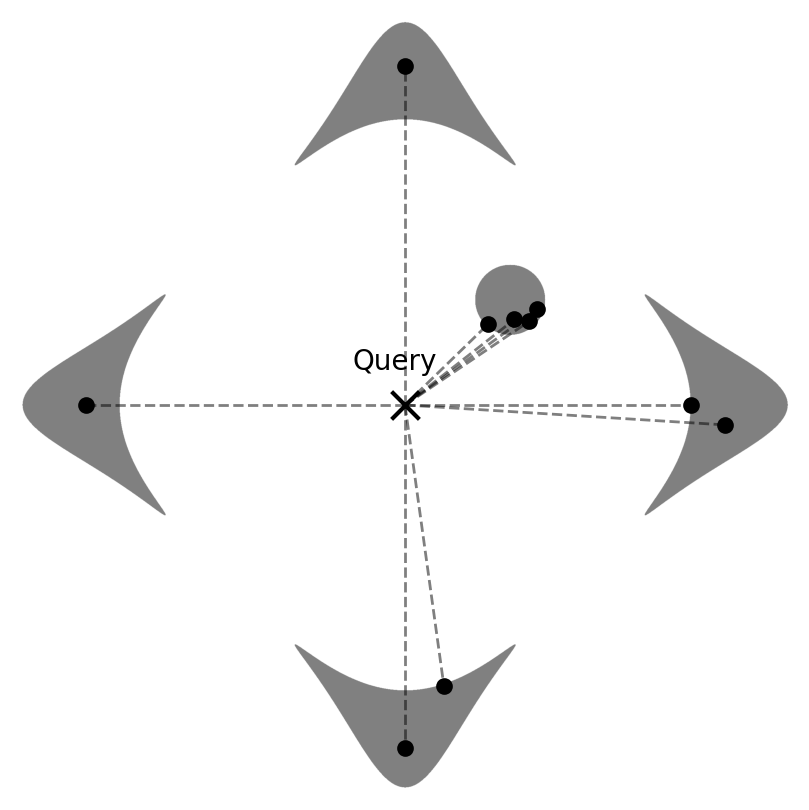

In [7]:
counterfactuals = generator.sample_with_dtai(num_samples=10, gower_weight=1,
                                             avg_gower_weight=0.5, cfc_weight=0.5,
                                             diversity_weight=0.2, include_dataset=False,
                                             num_dpp=10000)
plotcfs(validity, counterfactuals.values, (0,0), np.array([[-1.1,1.1],[-1.1,1.1]]))

Let's take a look at all the valid designs found over the course of optimization:

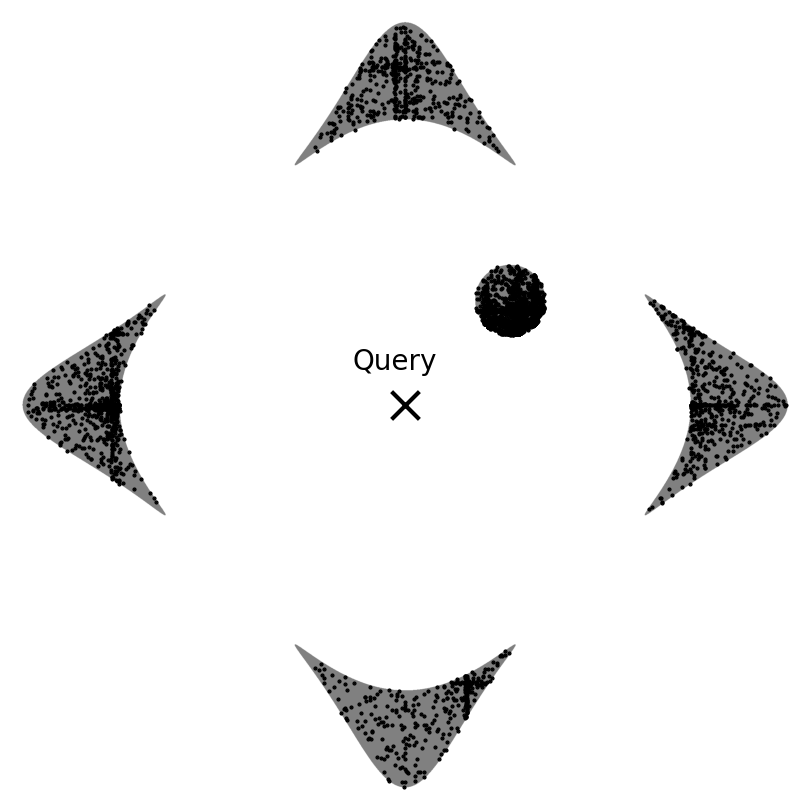

In [8]:
plotcfs(validity, generator._all_cf_x, (0,0), np.array([[-1.1,1.1],[-1.1,1.1]]), dataset=True)

Next, we'll weight proximity high:

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


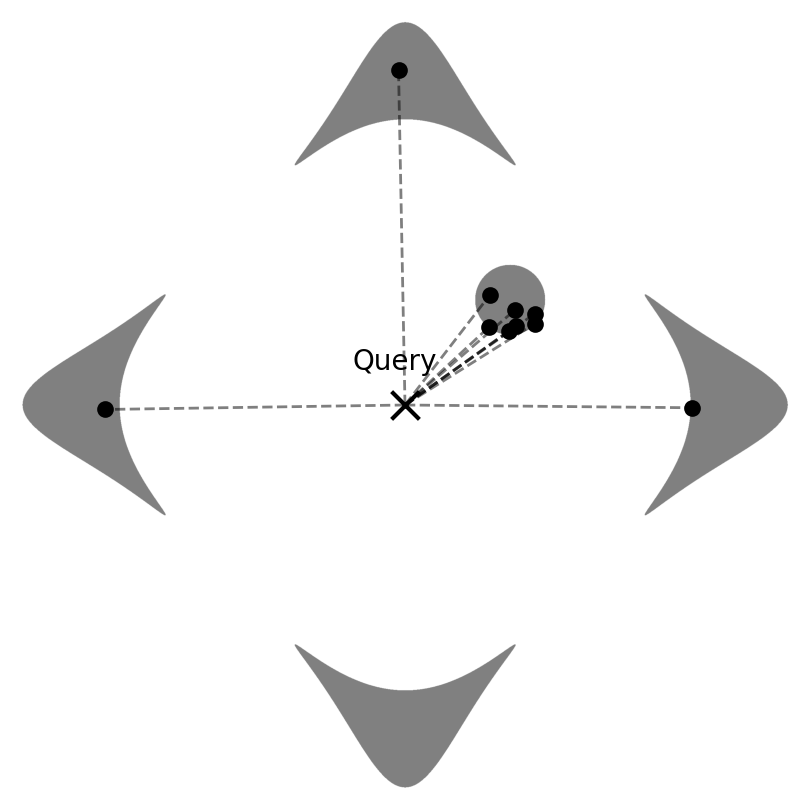

In [9]:
counterfactuals = generator.sample_with_dtai(num_samples=10, gower_weight=100,
                                             avg_gower_weight=0.5, cfc_weight=0.5,
                                             diversity_weight=0.2, include_dataset=False,
                                             num_dpp=10000)
plotcfs(validity, counterfactuals.values, (0,0), np.array([[-1.1,1.1],[-1.1,1.1]]))

Next, sparsity:

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


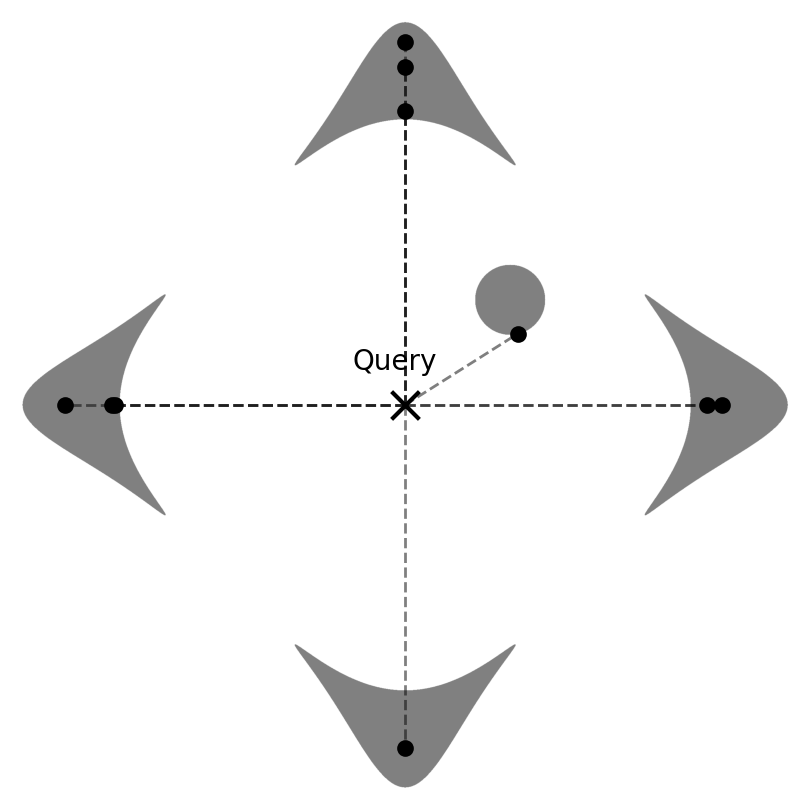

In [10]:
counterfactuals = generator.sample_with_dtai(num_samples=10, gower_weight=1,
                                             avg_gower_weight=0.5, cfc_weight=50,
                                             diversity_weight=0.2, include_dataset=False,
                                             num_dpp=10000)
plotcfs(validity, counterfactuals.values, (0,0), np.array([[-1.1,1.1],[-1.1,1.1]]))

Next, Diversity

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


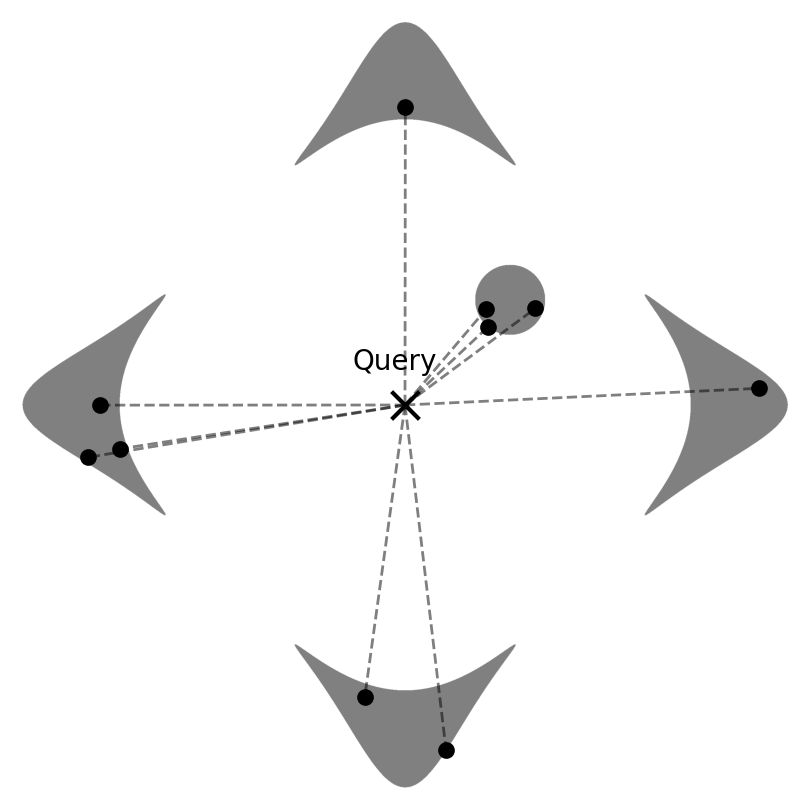

In [11]:
counterfactuals = generator.sample_with_dtai(num_samples=10, gower_weight=1,
                                             avg_gower_weight=0.5, cfc_weight=0.5,
                                             diversity_weight=20, include_dataset=False, 
                                             num_dpp=10000)
plotcfs(validity, counterfactuals.values, (0,0), np.array([[-1.1,1.1],[-1.1,1.1]]))

In [6]:
import sys
sys.path.append('../src/')

import decode_mcd
import decode_mcd.multi_objective_problem as MOP
from decode_mcd import data_package
from decode_mcd import design_targets
from decode_mcd import counterfactuals_generator
import numpy as np

In [60]:
def mixed_gower(x1: pd.DataFrame, x2: pd.DataFrame, ranges: np.ndarray, datatypes: dict):
    real_indices = datatypes.get("r", ())
    x1_real = x1.values[:, real_indices]
    x2_real = x2.values[:, real_indices]
    dists = np.expand_dims(x1_real, 1) - np.expand_dims(x2_real, 0)
    # TODO: check whether np.divide will broadcast shapes as desired in all cases
    scaled_dists = np.divide(dists, ranges)

    categorical_indices = datatypes.get("c", ())
    x1_categorical = x1.values[:, categorical_indices]
    x2_categorical = x2.values[:, categorical_indices]
    categorical_dists = np.not_equal(np.expand_dims(x1_categorical, 1), np.expand_dims(x2_categorical, 0))

    all_dists = np.concatenate([scaled_dists, categorical_dists], axis=2)
    total_number_of_features = x1.shape[1]
    GD = np.divide(np.abs(all_dists), total_number_of_features)
    GD = np.sum(GD, axis=2)
    return GD.astype(float)


def categorical_gower(first: pd.DataFrame, second: pd.DataFrame):
    return categorical_gower_np(first.values, second.values)


def categorical_gower_np(first: np.ndarray, second: np.ndarray):
    return np.divide(np.count_nonzero(first - second, axis=1), second.shape[1])


def euclidean_distance(dataframe: pd.DataFrame, reference: pd.DataFrame):
    rows = dataframe.values
    reference_row = reference.iloc[0].values
    return np.linalg.norm((rows - reference_row), axis=1)


def avg_gower_distance(dataframe: pd.DataFrame, reference_dataframe: pd.DataFrame,
                       ranges, datatypes, k=3) -> np.array:
    k = min(k, len(reference_dataframe))
    GD = mixed_gower(dataframe, reference_dataframe, ranges, datatypes)
    bottomk = np.partition(GD, kth=k - 1, axis=1)[:, :k]
    return np.mean(bottomk, axis=1)


def gower_distance(dataframe: pd.DataFrame, reference_dataframe: pd.DataFrame, ranges):
    dists = np.expand_dims(dataframe.values, 1) - np.expand_dims(reference_dataframe.values, 0)
    scaled_dists = np.divide(dists, ranges)
    GD = np.mean(np.abs(scaled_dists), axis=2)
    return GD


def changed_features_ratio(designs_dataframe: pd.DataFrame,
                           reference_dataframe: pd.DataFrame,
                           n_features: int):
    designs = designs_dataframe.values
    reference = reference_dataframe.iloc[0].values
    changes = np.count_nonzero(np.not_equal(designs, reference), axis=1)
    return changes / n_features


def to_dataframe(numpy_array: np.ndarray):
    dummy_columns = [_ for _ in range(numpy_array.shape[1])]
    return pd.DataFrame(numpy_array, columns=dummy_columns)

In [160]:
from pymoo.core.variable import Real, Integer, Binary, Choice
r1 = np.random.rand(1000, 2)
r2 = np.random.choice([0], 1000)
r1[:100] = np.random.rand(100, 2)*1000
# r2[:10] = np.array(range(10))+2
mixed_df = pd.DataFrame(np.concatenate([r1, r2.reshape(-1,1)], axis=1), columns=["X", "Y", "O1"])
datatypes = {"r": [0, 1], "c": [2]}

In [161]:
datatypes.get("X", ())

()

In [162]:
mixed_df

,X,Y,O1
0,78.809735,891.222141,0.0
1,723.604215,255.659692,0.0
2,338.584421,1.294032,0.0
3,25.738751,920.669389,0.0
4,778.338908,802.554786,0.0
...,...,...,...
995,0.936919,0.276432,0.0
996,0.776824,0.311117,0.0
997,0.330689,0.136688,0.0
998,0.210940,0.657052,0.0


In [166]:
matrix = mixed_gower(mixed_df, mixed_df, np.array([1,1]), datatypes)

In [172]:
matrix

array([[0.00000000e+00, 4.26785643e+02, 3.83234265e+02, ...,
        3.23188166e+02, 3.23054628e+02, 3.22875798e+02],
       [4.26785643e+02, 0.00000000e+00, 2.13128485e+02, ...,
        3.26265510e+02, 3.26131972e+02, 3.25953142e+02],
       [3.83234265e+02, 2.13128485e+02, 0.00000000e+00, ...,
        1.13137025e+02, 1.13003487e+02, 1.12824657e+02],
       ...,
       [3.23188166e+02, 3.26265510e+02, 1.13137025e+02, ...,
        0.00000000e+00, 2.13370824e-01, 3.12368547e-01],
       [3.23054628e+02, 3.26131972e+02, 1.13003487e+02, ...,
        2.13370824e-01, 0.00000000e+00, 1.78830077e-01],
       [3.22875798e+02, 3.25953142e+02, 1.12824657e+02, ...,
        3.12368547e-01, 1.78830077e-01, 0.00000000e+00]])

In [175]:
L = np.exp(1-matrix)
print(min(np.linalg.eigvals(L)))

0.0009036116199314895


In [170]:
print(L)

[[2.71828183e+000 1.21239667e-185 9.94873724e-167 ... 1.18975410e-140
  1.35972859e-140 1.62598728e-140]
 [1.21239667e-185 2.71828183e+000 7.47772607e-093 ... 5.48256504e-142
  6.26583297e-142 7.49279290e-142]
 [9.94873724e-167 7.47772607e-093 2.71828183e+000 ... 1.99300654e-049
  2.27773788e-049 2.72375888e-049]
 ...
 [1.18975410e-140 5.48256504e-142 1.99300654e-049 ... 2.71828183e+000
  2.19598167e+000 1.98899891e+000]
 [1.35972859e-140 6.26583297e-142 2.27773788e-049 ... 2.19598167e+000
  2.71828183e+000 2.27315770e+000]
 [1.62598728e-140 7.49279290e-142 2.72375888e-049 ... 1.98899891e+000
  2.27315770e+000 2.71828183e+000]]


In [171]:
from numpy.random import randn
import numpy as np
from dppy.finite_dpps import FiniteDPP
r, N = 5, 10

# Random feature vectors
# Phi = randn(r, N)
DPP = FiniteDPP('likelihood', **{'L': L}) 

k = 3
DPP.flush_samples()
for _ in range(10):
    DPP.sample_exact_k_dpp(size=3)

DPP.list_of_samples

0.0009036116199321965


[[483, 968, 294],
 [492, 517, 314],
 [558, 253, 775],
 [24, 353, 106],
 [951, 803, 836],
 [22, 903, 666],
 [80, 496, 55],
 [931, 25, 372],
 [318, 2, 177],
 [735, 924, 59]]

In [9]:
test = np.random.rand(100, 100)
test = test+test.T
multiplier = np.arange(100)**2

In [10]:
test = multiplier.T*test*multiplier

In [11]:
eigval, eigvec = np.linalg.eig(test)

In [12]:
print(min(eigval))

-276509704.79771876


In [19]:
from dppy.finite_dpps import FiniteDPP
DPP = FiniteDPP('likelihood', **{'L': test.T.dot(test)})
k = 3
DPP.flush_samples()
for _ in range(10):
    DPP.sample_exact_k_dpp(size=3)

DPP.list_of_samples

0.0


[[91, 96, 94],
 [93, 95, 88],
 [97, 98, 86],
 [89, 80, 86],
 [84, 96, 92],
 [95, 87, 91],
 [93, 99, 88],
 [96, 81, 87],
 [98, 90, 96],
 [93, 90, 98]]

In [20]:
from numpy import linalg as la 
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

In [21]:
isPD(test)

False